# Requirements

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

# Laboratory Exercise - Run Mode (8 points)

## The Vacation Preferences Dataset
The dataset contains information about individuals and their vacation preferences. It includes details such as age, gender, income, and education level. It also provides insights into their vacation habits, like the number of vacations taken each year, preferred activities (such as hiking, swimming, skiing, or sunbathing), and their budget for vacations. Other information includes the type of place they live in (urban, suburban, or rural), how far they live from mountains and beaches, and their favorite season for vacations (summer, winter, spring, or fall). The dataset also contains information whether they have pets and if they are concerned about the environment. All these features serve as input variables for predictive modeling. The 'Preference' attribute serves as the target variable, where 1 represents preference for mountains, 0 for beaches.

Load the dataset into a `pandas` data frame.

In [2]:
data = pd.read_csv("data/vacation_preferences_data.csv")

In [3]:
data.sample(5)

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
49887,45.0,male,27880,doctorate,1,swimming,3641,rural,250.0,184,summer,1,1,0
31447,22.0,non-binary,38546,master,2,swimming,4257,rural,54.0,159,fall,1,1,0
47001,63.0,non-binary,70982,master,4,sunbathing,3894,rural,145.0,88,spring,0,1,0
10524,51.0,male,65108,master,4,sunbathing,2563,urban,293.0,267,winter,1,1,0
8779,34.0,male,52605,high school,9,sunbathing,1918,rural,43.0,84,summer,0,1,0


In [4]:
data_copy = data.copy()

In [5]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52444 entries, 0 to 52443
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     47200 non-null  float64
 1   Gender                  52444 non-null  object 
 2   Income                  52444 non-null  int64  
 3   Education_Level         49822 non-null  object 
 4   Travel_Frequency        52444 non-null  int64  
 5   Preferred_Activities    52444 non-null  object 
 6   Vacation_Budget         52444 non-null  int64  
 7   Location                52444 non-null  object 
 8   Proximity_to_Mountains  49822 non-null  float64
 9   Proximity_to_Beaches    52444 non-null  int64  
 10  Favorite_Season         52444 non-null  object 
 11  Pets                    52444 non-null  int64  
 12  Environmental_Concerns  52444 non-null  int64  
 13  Preference              52444 non-null  int64  
dtypes: float64(2), int64(7), object(5)
mem

Preprocess the input and the output variables appropriately.

In [6]:
def encode_funct(encoder, column):
    encoded_values = encoder.fit_transform(data_copy[column])
    data_copy[column] = encoded_values
    print(encoder.classes_)

In [7]:
encode_funct(LabelEncoder(),'Preferred_Activities')

['hiking' 'skiing' 'sunbathing' 'swimming']


In [8]:
encode_funct(LabelEncoder(),'Location')

['rural' 'suburban' 'urban']


In [9]:
encode_funct(LabelEncoder(),'Favorite_Season')

['fall' 'spring' 'summer' 'winter']


In [30]:
encode_funct(LabelEncoder(),'Gender')

['female' 'male' 'non-binary']


In [10]:
data_copy['Education_Level'] = data_copy['Education_Level'].fillna('nan')
categories = [['high school', 'bachelor', 'master', 'doctorate','nan']]
encoder = OrdinalEncoder(categories=categories)

In [11]:
data_copy['Education_Level'] = encoder.fit_transform(data_copy[['Education_Level']])
encoder.categories_

[array(['high school', 'bachelor', 'master', 'doctorate', 'nan'],
       dtype=object)]

In [12]:
data['Education_Level'].isnull().sum()

2622

In [13]:
for i in range(len(data_copy)):
    if data_copy.loc[i, 'Education_Level'] == 4:
        data_copy.loc[i, 'Education_Level'] = np.nan

Explore the dataset using visualizations of your choice.

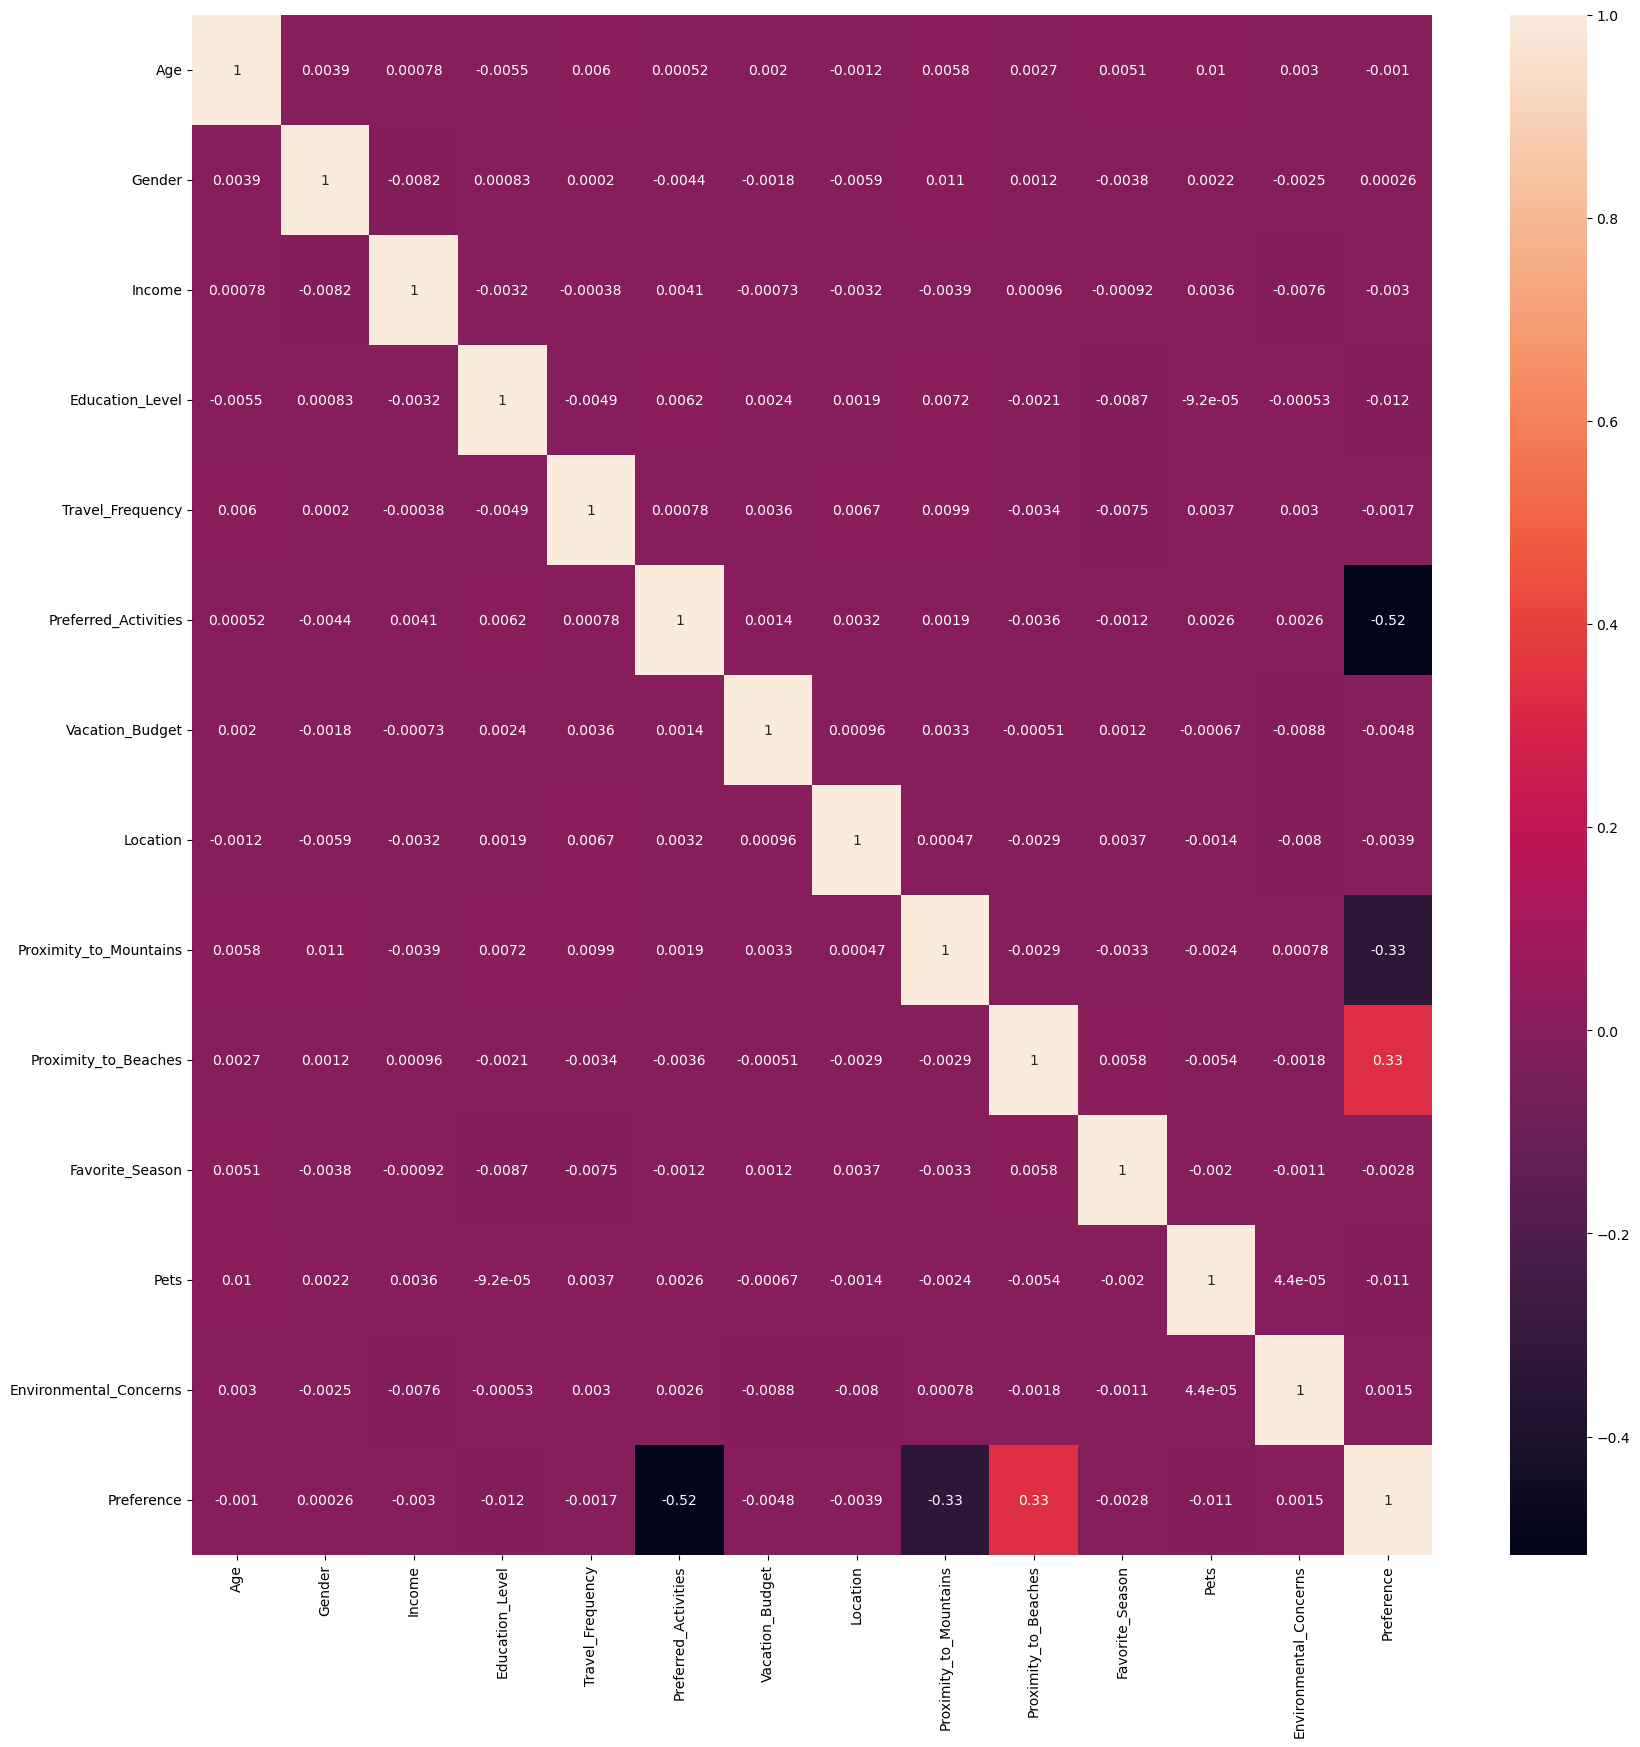

In [31]:
plt.figure(figsize=(20, 20))
sns.heatmap(data_copy.corr(), annot=True)
plt.show()

Check if the dataset is balanced.

In [32]:
b = data_copy['Preference'].value_counts() / len(data) * 100
b = b.reset_index()
b

,Preference,count
0,0,74.929449
1,1,25.070551


## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [28]:
missing_percent = data_copy.isnull().sum() / len(data) * 100
missing_percent = missing_percent.reset_index().rename(columns={"index": "column", 0: "percent missing"})
missing_percent

,column,percent missing
0,Age,9.999237
1,Gender,0.000000
2,Income,0.000000
3,Education_Level,4.999619
4,Travel_Frequency,0.000000
5,Preferred_Activities,0.000000
6,Vacation_Budget,0.000000
7,Location,0.000000
8,Proximity_to_Mountains,4.999619
9,Proximity_to_Beaches,0.000000


## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts.

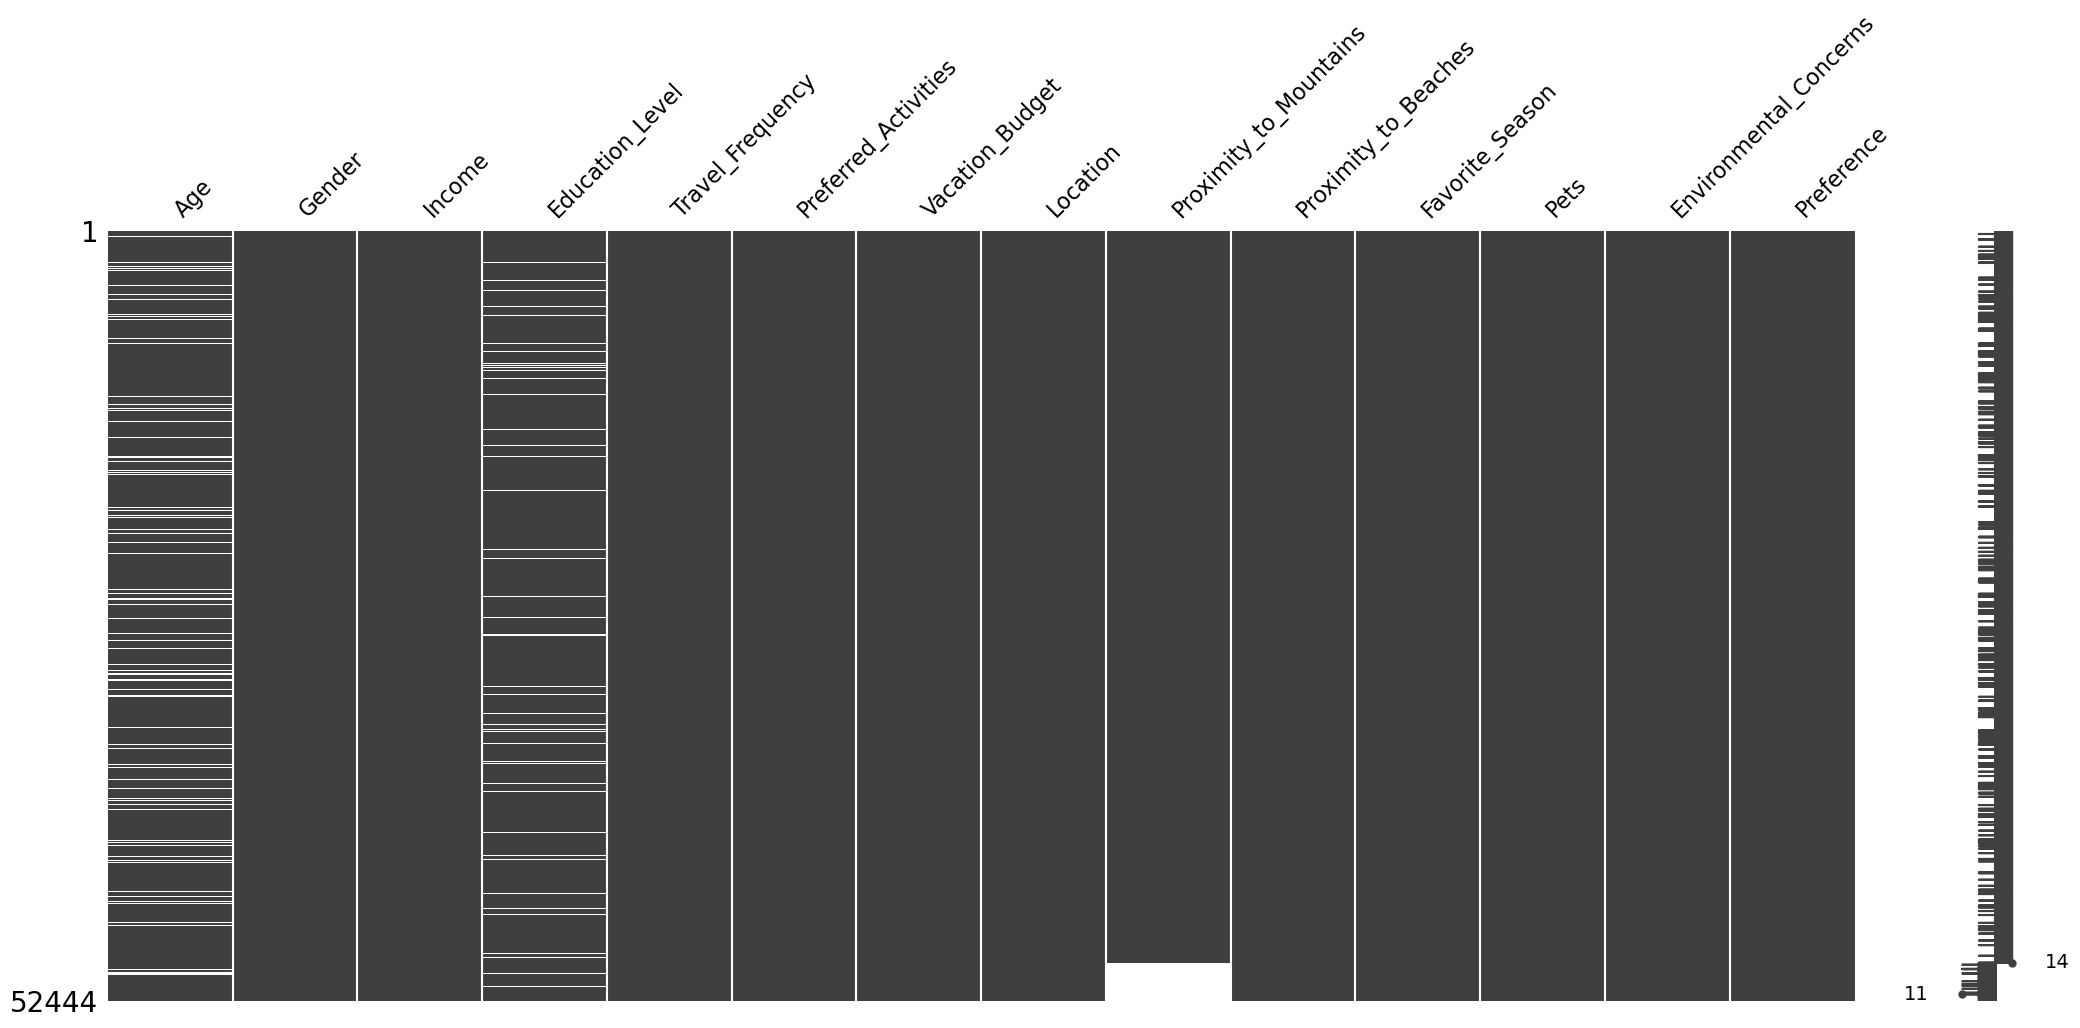

In [36]:
msno.matrix(data.sort_values('Proximity_to_Mountains'))
plt.show()

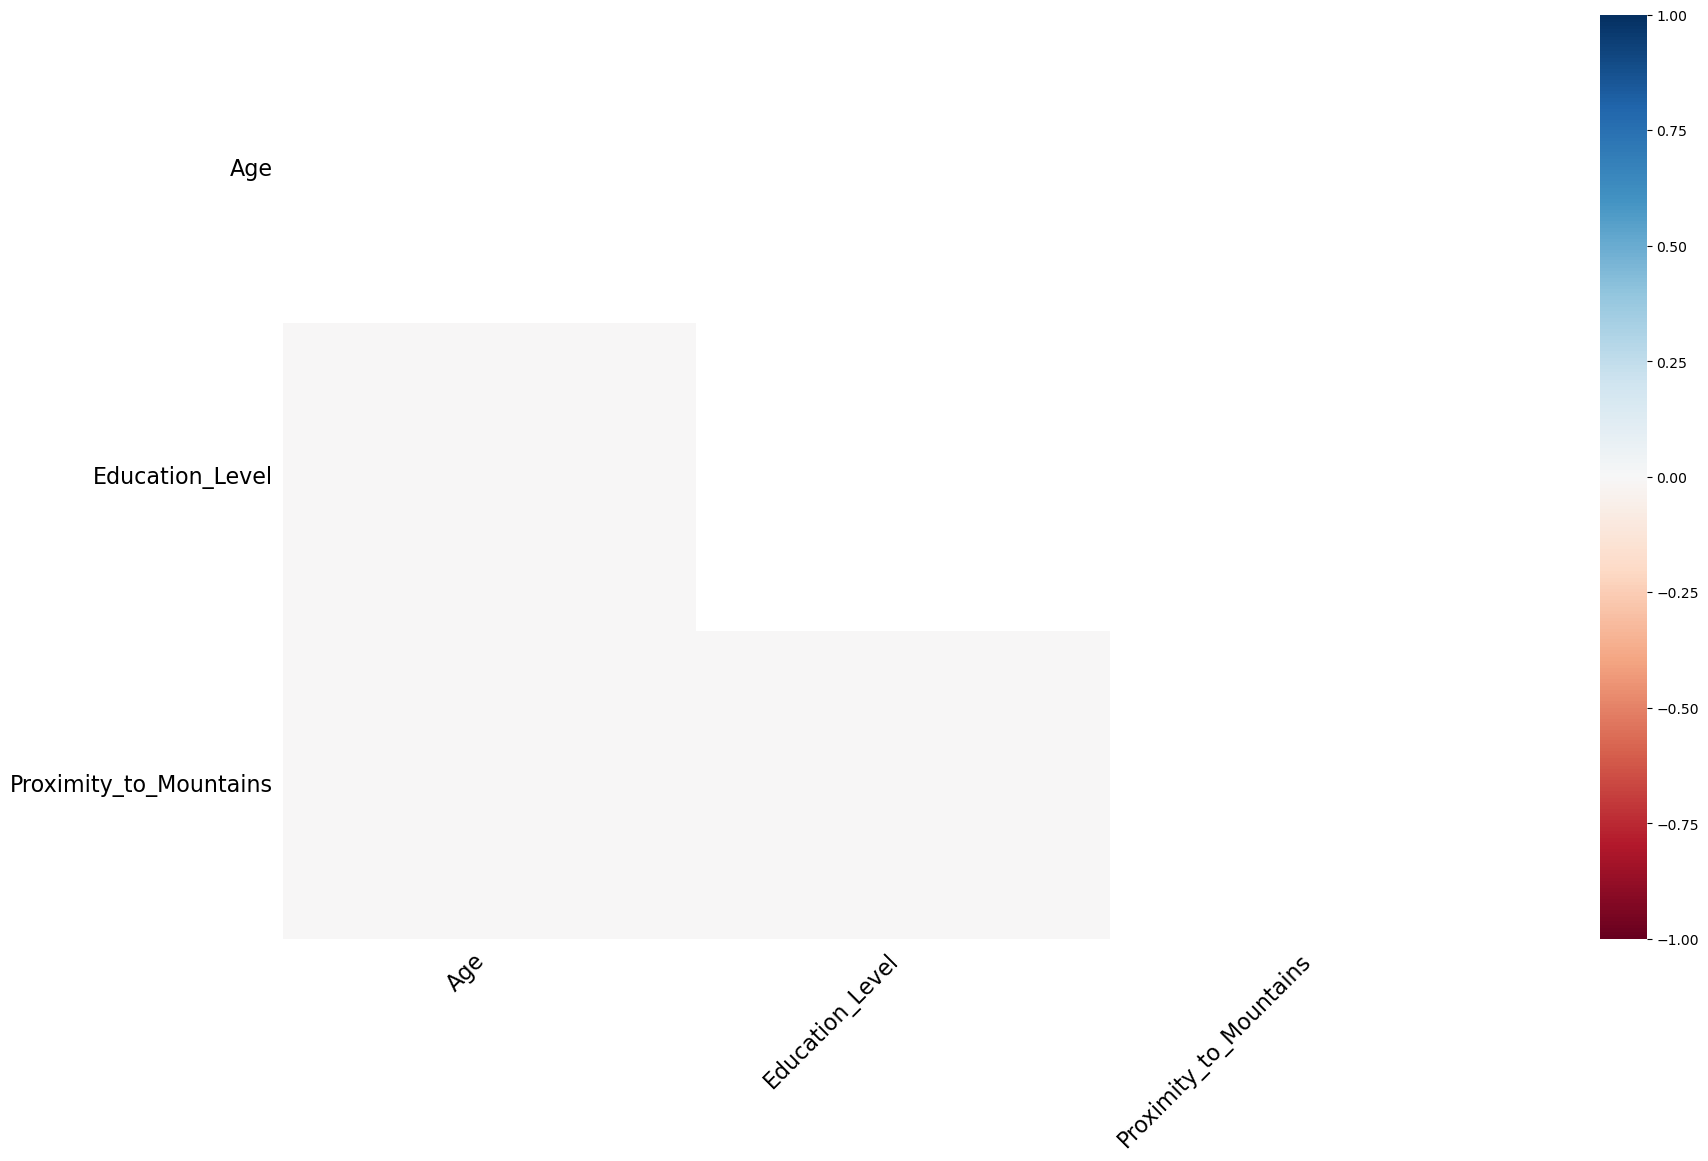

In [37]:
msno.heatmap(data)
plt.show()

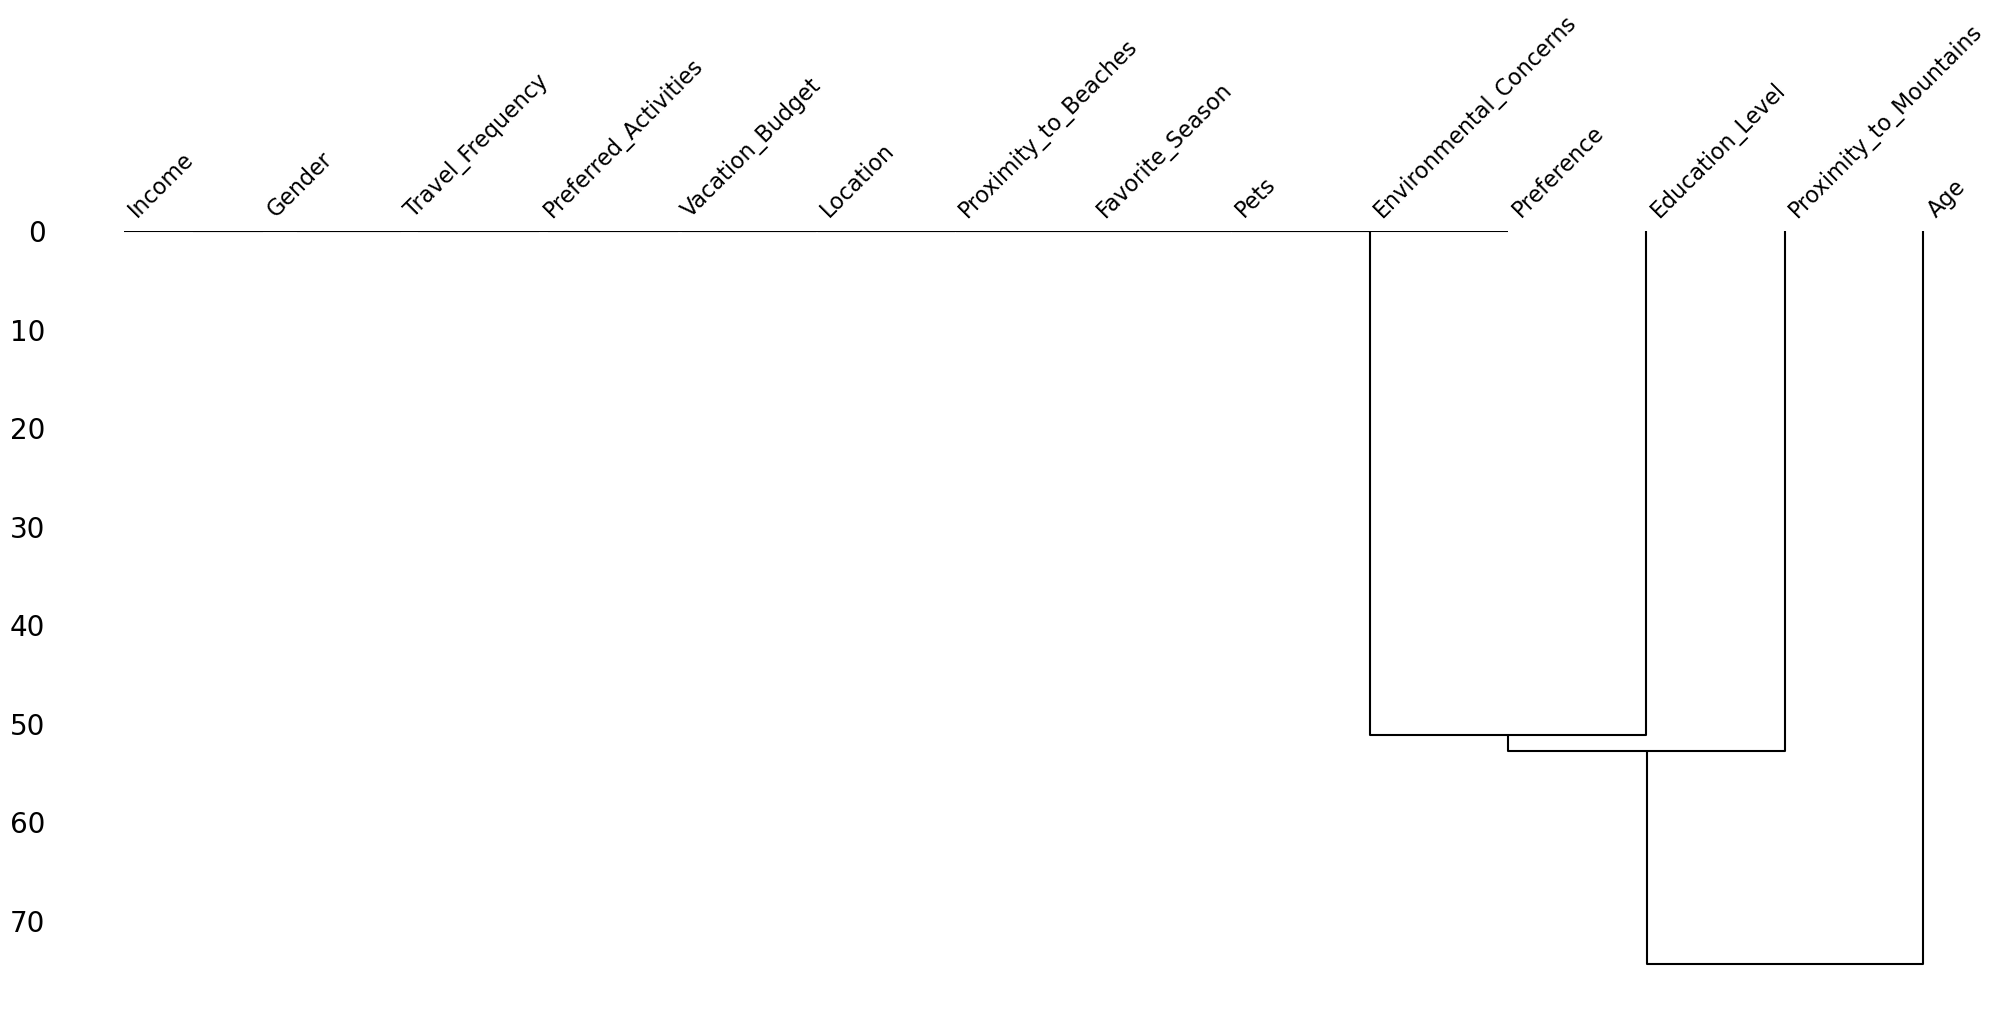

In [38]:
msno.dendrogram(data)
plt.show()

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [39]:
data_copy['Age'] = data_copy['Age'].fillna(data_copy['Age'].mean())

In [41]:
data_copy.isnull().sum()

Age                          0
Gender                       0
Income                       0
Education_Level           2622
Travel_Frequency             0
Preferred_Activities         0
Vacation_Budget              0
Location                     0
Proximity_to_Mountains    2622
Proximity_to_Beaches         0
Favorite_Season              0
Pets                         0
Environmental_Concerns       0
Preference                   0
dtype: int64

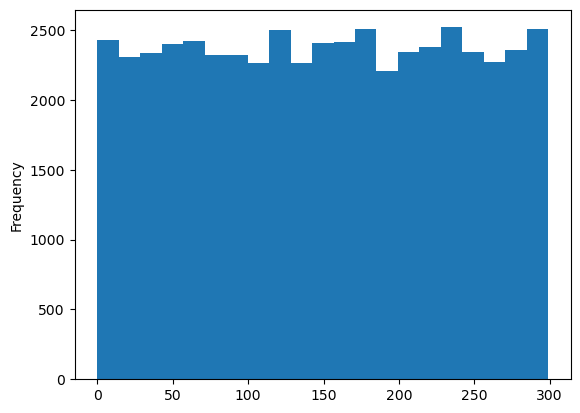

In [43]:
data_copy['Proximity_to_Mountains'].plot.hist(bins=21)
plt.show()

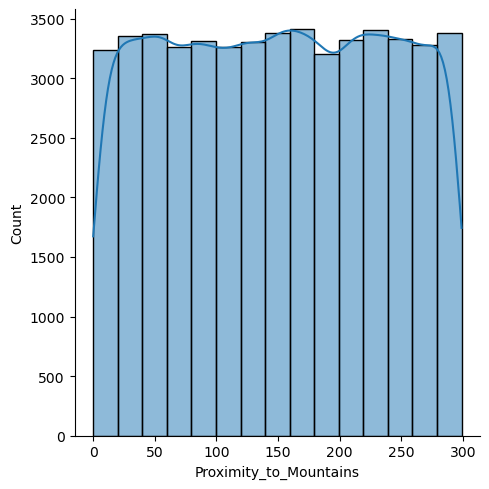

In [44]:
sns.displot(data_copy['Proximity_to_Mountains'], kde=True, bins=15)
plt.show()

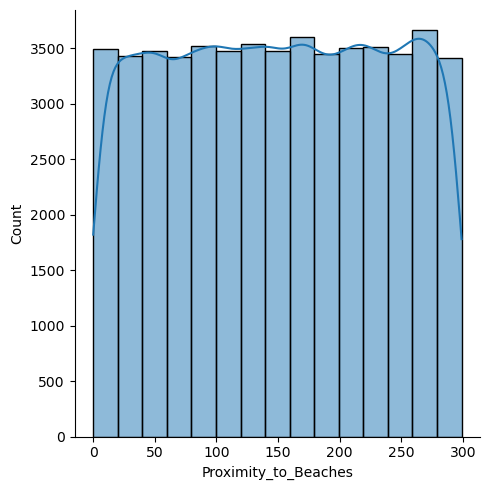

In [48]:
sns.displot(data_copy['Proximity_to_Beaches'], kde=True, bins=15)
plt.show()

In [45]:
data_copy['Proximity_to_Mountains'].describe()

count    49822.000000
mean       149.875878
std         86.537579
min          0.000000
25%         75.000000
50%        150.000000
75%        225.000000
max        299.000000
Name: Proximity_to_Mountains, dtype: float64

In [47]:
data_copy['Proximity_to_Mountains'].median()

150.0

In [49]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_copy[['Proximity_to_Beaches', 'Proximity_to_Mountains']])
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(scaled_data)
imputed_data = scaler.inverse_transform(imputed_data)
data_copy[['Proximity_to_Beaches', 'Proximity_to_Mountains']] = imputed_data

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [51]:
X = data_copy.drop(['Preference'],axis=1)
Y = data_copy['Preference']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

## Feature Scaling
Standardize the features appropriately.

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Selection

Choose and train an approriate model for the given task.

In [60]:
model = XGBClassifier(max_depth=5,max_leaves=50,learning_rate=0.1)
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=50,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [61]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different classification metrics.

In [62]:
print(accuracy_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred,average='micro'))
print(f1_score(Y_test,y_pred,average='macro'))
print(confusion_matrix(Y_test,y_pred))

0.9865573457908284
0.9865573457908284
0.9818684179183232
[[7841   90]
 [  51 2507]]


# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune at least one hyper-parameter using a cross-validation with grid search. This involves systematically experimenting with various values for the hyper-parameter(s) and evaluating the model's performance using cross-validation. Upon determining the most suitable value(s) for the hyper-parameter(s), evaluate the model's performance on a test set for final assessment.

Hint: Use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

In [63]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1)

## Feature Scaling
Standardize the features appropriately.

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Fine-tuning the Hyperparameters
Experiment with various values for the chosen hyperparameter(s) and evaluate the model's performance using cross-validation.

In [68]:
model = XGBClassifier()
param_grid = {
    'learning_rate' :[0.1],
    'max_depth' :[10,8,15],
    'max_leaves':[50,100]
}
cv = GridSearchCV(estimator=model,param_grid=param_grid)
cv.fit(X_train,Y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [10, 8, 15],
                         'max_leaves': [50, 100]})

In [69]:
model = cv.best_estimator_
y_pred = model.predict(X_test)

## Final Assessment of the Model Performance
Upon determining the most suitable hyperparameter(s), evaluate the model's performance on a test set for final assessment.

In [70]:
print(accuracy_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred,average='micro'))
print(f1_score(Y_test,y_pred,average='macro'))
print(confusion_matrix(Y_test,y_pred))

0.8667302192564347
0.8667302192564347
0.8424229334760283
[[3303  677]
 [  22 1243]]
